In [1]:
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
import tensorflow.keras.preprocessing.sequence
import math
import warnings
import os
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy import signal
from tqdm import tqdm
import ast
import ecg_plot
from sklearn.metrics import accuracy_score

In [2]:
sr = 100
quick_load = True

In [3]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    def load_data():
        ptb = pd.read_csv('../data/ptbxl_database.csv')
        def load_raw_data(df, sampling_rate, path):
            if(sampling_rate == 100):
                data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
            else:
                data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
            data = np.array([signal for signal, meta in data])
            return data
        
        # load and convert annotation data
        Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data(Y, sr, '../data/')

        # Load scp_statements.csv for diagnostic aggregation
        agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
        agg_df = agg_df[agg_df.diagnostic == 1]

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in agg_df.index:
                    tmp.append(agg_df.loc[key].diagnostic_class)
            return list(set(tmp))


        # Apply diagnostic superclass
        Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
        return X, Y

### Simple load function to remove overhead

In [4]:
if(quick_load):
    X = np.load('../data/X_raw.npy')
    Y = pd.read_csv('../data/Y_raw.csv')
else:
    X,Y = load_data()

### Filtering out abnormal ECGs to train GANS
* Filters for normal ECGs from ages 18 to 30

In [5]:
def subset_age(X, Y, age_lower, age_upper):
    X2 = X[(Y.age < age_upper) & (Y.age >= age_lower)]
    Y2 = Y[(Y.age < age_upper) & (Y.age >= age_lower)]
    X_sub = X2[Y2.diagnostic_superclass == "['NORM']"]
    Y_sub = X2[Y2.diagnostic_superclass == "['NORM']"]
    return X_sub, Y_sub

X_sub, Y_sub = subset_age(X, Y, 18, 30)


In [6]:
len(X_sub)

1023

In [7]:
(Y.diagnostic_superclass).unique()

array(["['NORM']", "['MI']", '[]', "['STTC']", "['HYP']", "['CD']",
       "['MI', 'STTC']", "['CD', 'HYP']", "['CD', 'MI']",
       "['CD', 'STTC']", "['MI', 'HYP']", "['MI', 'STTC', 'HYP']",
       "['CD', 'MI', 'HYP', 'STTC']", "['STTC', 'HYP']", "['CD', 'NORM']",
       "['STTC', 'MI', 'HYP']", "['CD', 'MI', 'STTC']",
       "['STTC', 'HYP', 'CD']", "['CD', 'STTC', 'HYP']",
       "['STTC', 'MI', 'HYP', 'CD']", "['NORM', 'STTC']",
       "['CD', 'HYP', 'STTC']", "['CD', 'MI', 'HYP']",
       "['CD', 'MI', 'STTC', 'HYP']", "['CD', 'NORM', 'STTC']",
       "['CD', 'NORM', 'HYP']", "['NORM', 'HYP']",
       "['CD', 'NORM', 'MI', 'HYP']"], dtype=object)

### Generator Utility Functions
- Generate Real Samples
    * Selects a random index to display a real ECG signal. Also returns n number of 1s because these are real samples.
- Generate Latent Points
    * Feeding the GANS model the entire (1000,12) data would be way too time and resource extensive. 
    * This generator doesnt learn, it is simply a seed for the Generator. What changes in the generator's ability to learn from these latent points
- Generate Fake Samples
    * Uses the generator and latent_dim to generate a batch of n fake ECGs. Also generates array of 0s because these are fake. 
- ECG Visualization
    * One function displays a specified lead from each real and fake ECG.
    * The 12 lead version displays all 12 leads. *(Decided not to use in loop because it is resource, time, and space extensive)*


In [8]:
# generate n real samples with class labels
def generate_real_samples(ecgsignal,n):
    """Randomly pick n real ECG samples from the dataset and return it together with an array of n ones """
    # generate inputs in [-0.5, 0.5]
    X = ecgsignal[np.random.choice(ecgsignal.shape[0],n)]
    # generate class labels
    y = tf.ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    """Generate random numbers used as input to the generator """
    # generate points in the latent space
    x_in = np.random.randn(latent_dim*n).reshape(n,latent_dim)
    # reshape into a batch of inputs for the network
    return np.expand_dims(x_in,1)
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(latent_dim,generator,n):
    """Use the generator to generate fake ECGs"""
    # generate points in latent space
    x_input = generate_latent_points(latent_dim,n)
    # predict outputs
    X = generator(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

def compare_real_and_gen_ecg2(generated_ecg):
    """Plot real and generated ECGs side by side"""
    rand_idx = np.random.choice(np.arange(len(X_sub)))
    ecg_plot.plot_1(tf.transpose(X_sub, (0,2,1))[rand_idx, 1, :], sample_rate=sr, title = "Real ECG")
    ecg_plot.plot_1(tf.transpose(generated_ecg, (0,2,1))[0, 1, :], sample_rate=sr, title = "Fake ECG")
    plt.show()


def compare_real_and_gen_ecg_12(generated_ecg):
    """Plot real and generated ECGs side by side"""
    rand_idx = np.random.choice(np.arange(len(X_sub)))
    ecg_plot.plot_12(tf.transpose(X_sub, (0,2,1))[rand_idx, :, :], sample_rate=sr, title = "Real ECG")
    ecg_plot.plot_12(tf.transpose(generated_ecg, (0,2,1))[0, :, :], sample_rate=sr, title = "Fake ECG")
    plt.show()

### Discriminator Model
- Inception Model
    * Helps capture Patterns of varying lengths
    * Bottleneck layer is used to reduce dimensionality and increase efficiency. Optional because bottlenecking may reduce accuracy slighlty. In this case, it's pros outweight the very slight performance loss.
    * Finally, all the conv layers are concatenated and passed thorugh bath normalization to reach convergence faster
- Shortcut Layer (https://www.researchgate.net/figure/The-shortcut-connections-of-a-deep-residual-neural-network-ResNet-for-the-image_fig1_339109948)
    * Very commonly used in ResNet architecture
    * Info from initial layer gets lost, shortcut layer joins these initial layers with later ones.
    * Matches the intial shape with later shapes
    * Addressed vanishing gradient problem where the gradient values become exceedingly small after many updates.
    * Particularly important for gans because we are making many continuous updates to our gradient that our Generator and Discriminator is using.
- Dsicrminator
    * Uses inception modules to capture multi-scale patterns.
    * Uses Shortcut layer
    * Uses global average pooling layer which esentially takes the average of each dimension converting a vector or matrix into a scalar.
        - Reduces the number of parameters that we process which helps avoid over fitting. We are generalizing our layers before passing it into our dense layers.
    * We apply one final dense "sigmoid" layer because we want to create a classification of either 0 or 1.


In [9]:
import tensorflow as tf


def _inception_module(input_tensor, stride=1, activation="linear", use_bottleneck=True, kernel_size=40, bottleneck_size=32, nb_filters=32):

    # Optional bottleneck layer
    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1, padding="same", activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    # Different kernel sizes for capturing multi-scale patterns
    # Incremements kernel size until 40
    kernel_sizes = []
    for i in range(3):
        k_size = kernel_size // (2 ** i)
        kernel_sizes.append(k_size)

    conv_layers = []
    for k in kernel_sizes:
        conv_layer = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=k, strides=stride, padding="same", activation=activation, use_bias=False)(input_inception)
        conv_layers.append(conv_layer)

    # Max pooling to downsample and then convolve to get to the correct number of channels
    max_pooled = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding="same")(input_tensor)
    conv_pooled = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=1, padding="same", activation=activation, use_bias=False)(max_pooled)

    # Concatenate all feature maps and apply batch normalization
    concatenated_layers = conv_layers + [conv_pooled]
    x = tf.keras.layers.Concatenate(axis=2)(concatenated_layers)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation="relu")(x)

    return x



def _shortcut_layer(input_tensor, out_tensor):

    # Apply a 1D convolution to the input tensor to match the number of filters in the out_tensor
    filter_count = int(out_tensor.shape[-1])
    shortcut = tf.keras.layers.Conv1D(filters=filter_count, kernel_size=1, padding="same", use_bias=False)(input_tensor)

    # Apply batch normalization to the shortcut tensor
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # Add the shortcut tensor to the out_tensor
    combined_tensors = [shortcut, out_tensor]
    x = tf.keras.layers.Add()(combined_tensors)

    # Apply the ReLU activation function
    x = tf.keras.layers.Activation("relu")(x)

    return x



def discriminator(input_shape=(1000, 12), nb_classes=1, depth=1, use_residual=True):
    
    # Define the input layer
    input_layer = tf.keras.layers.Input(input_shape)
    x = input_layer
    input_res = input_layer  # This will be used for residual connections later

    # I found that using only 1 inception model does a good job under reasonable time.
    for d in range(depth):

        x = _inception_module(x)

        # Adding a shortcut layer every three layers
        if use_residual and d % 3 == 2:
            
            # Add the shortcut layer
            x = _shortcut_layer(input_res, x)
            
            # Update the input_res tensor for the next shortcut
            input_res = x

    # Reduce the spatial dimensions of the tensor using Global Average Pooling
    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Create the final output layer
    # For binary classification problems, this layer has only 1 unit and uses the sigmoid activation
    output_layer = tf.keras.layers.Dense(units=nb_classes, activation="sigmoid")(gap_layer)

    # Construct and compile the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    return model



### Generator

In [10]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12*1000, use_bias=False, input_shape=(1,12)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((1000,12)))
    # assert model.output_shape == (None, 1000, 12)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv1DTranspose(128, 5, strides= 1, padding='same', use_bias=False))
    # assert model.output_shape == (None, 1000, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(64,  5, strides= 1, padding='same', use_bias=False))
    # assert model.output_shape == (None, 1000, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(12, 5, strides=1, padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 1000, 12)
    return model

In [11]:
disc = discriminator()
gen = generator()

In [12]:
# res = gen(generate_latent_points(12,1))
# compare_real_and_gen_ecg(res)
# res.shape, X_sub[1].shape

### Training

Before training:


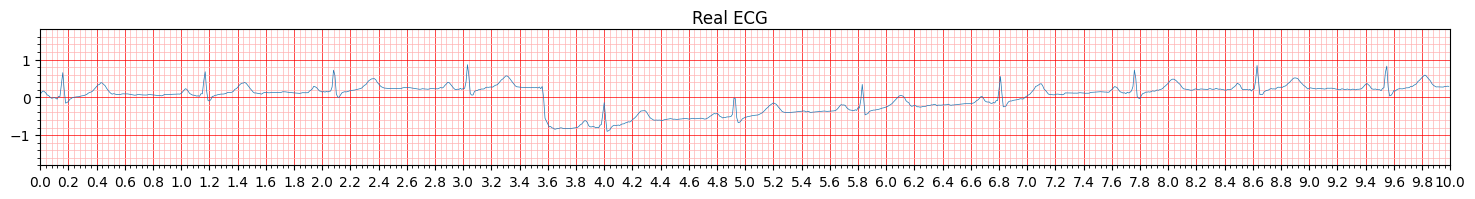

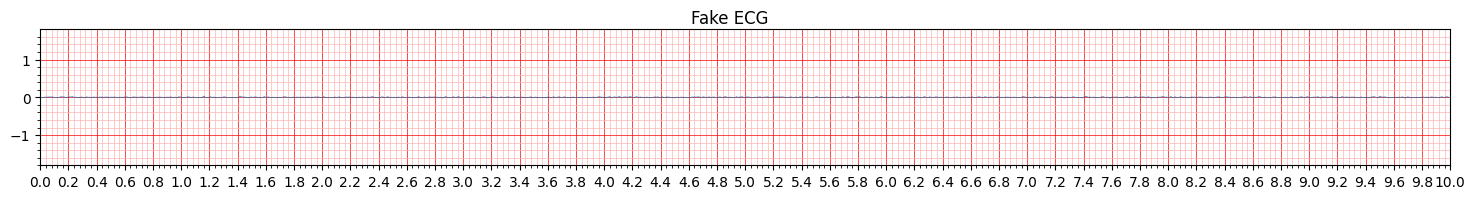

-------------------
epoch 0
epoch 1


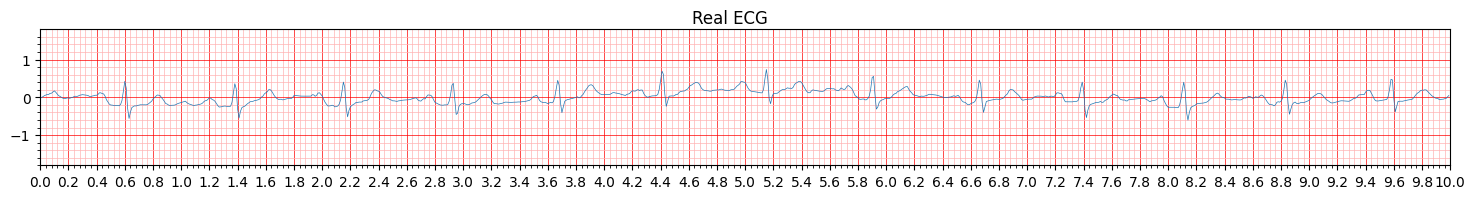

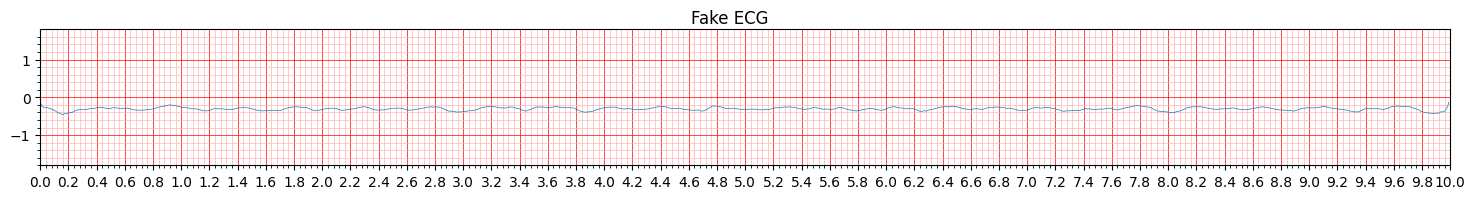

Generator Accuracy: 1.0
Generator Mean Loss: 0.6693675
Discriminator Accuracy: 0.5
Discriminator Mean Loss: 0.7473204
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26


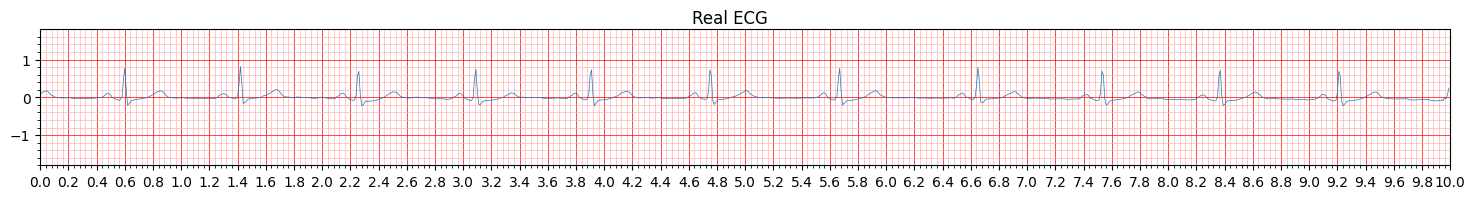

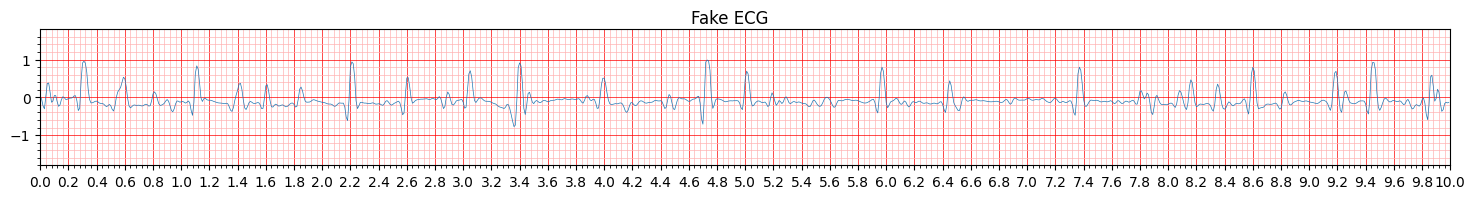

Generator Accuracy: 0.0
Generator Mean Loss: 0.7677058
Discriminator Accuracy: 0.453125
Discriminator Mean Loss: 0.684136
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51


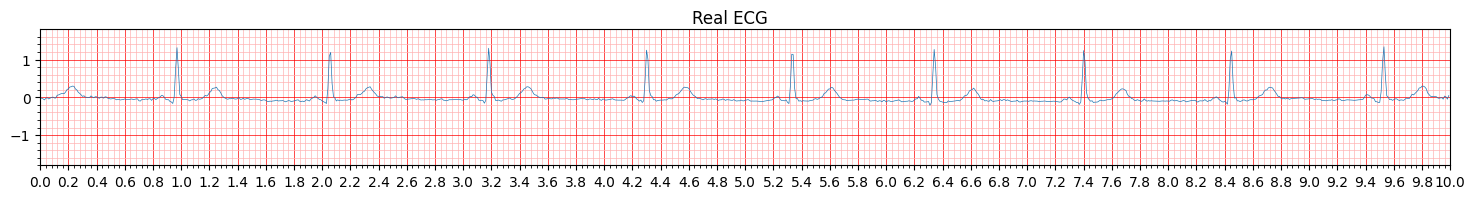

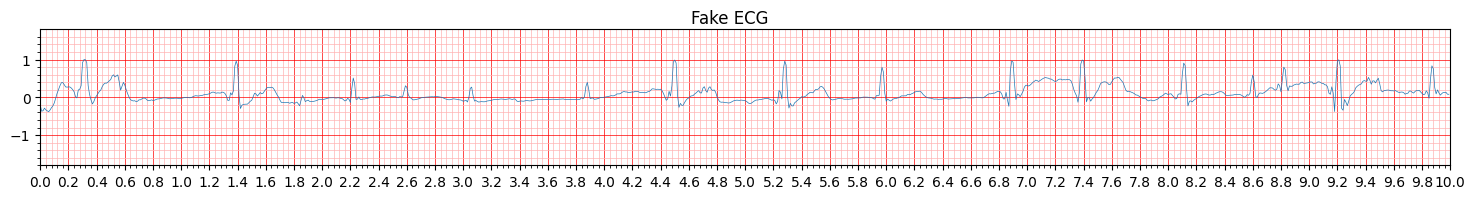

Generator Accuracy: 0.71875
Generator Mean Loss: 0.6665479
Discriminator Accuracy: 0.453125
Discriminator Mean Loss: 0.70319885
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76


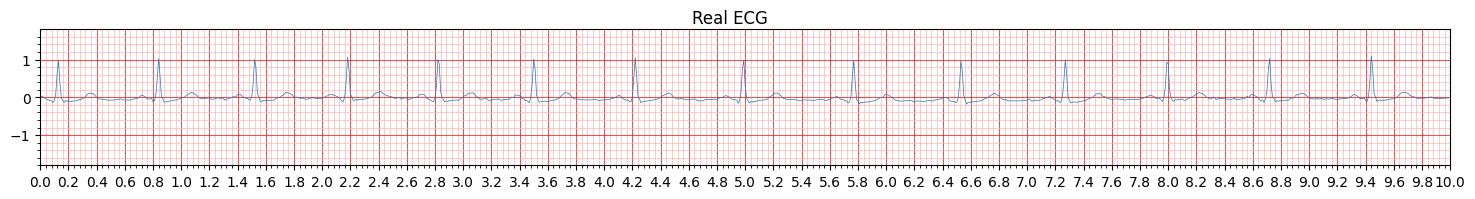

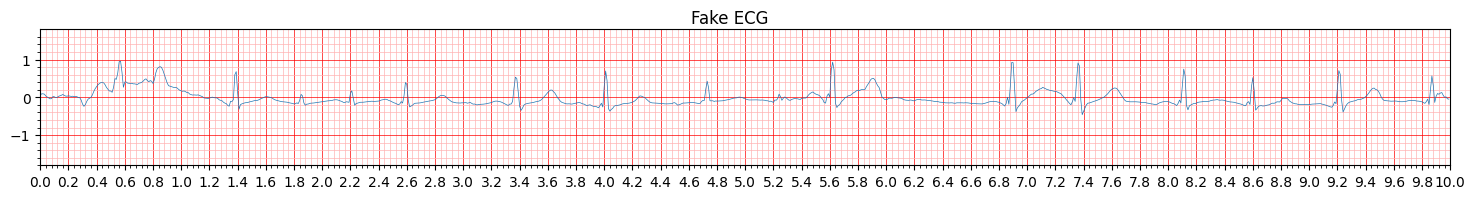

Generator Accuracy: 0.046875
Generator Mean Loss: 0.7138765
Discriminator Accuracy: 0.46875
Discriminator Mean Loss: 0.6929424
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101


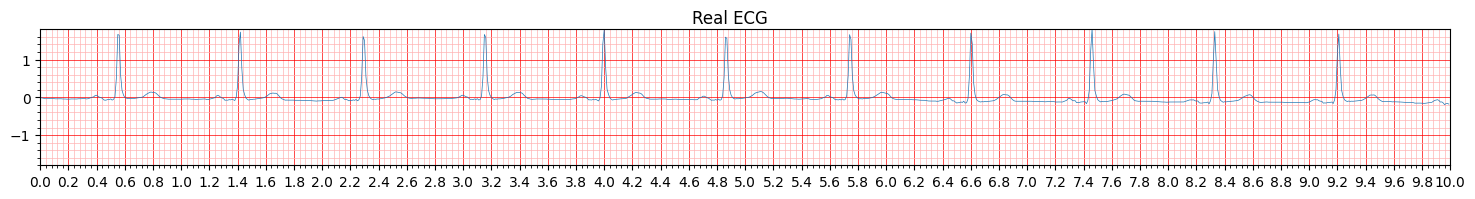

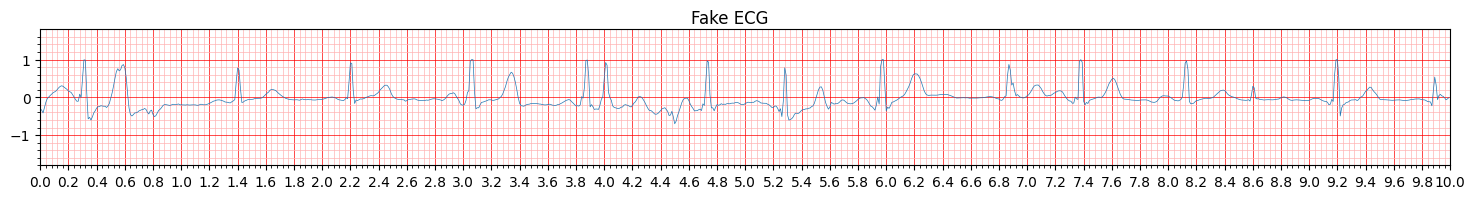

Generator Accuracy: 0.015625
Generator Mean Loss: 0.7017367
Discriminator Accuracy: 0.484375
Discriminator Mean Loss: 0.68481624
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110
epoch 111
epoch 112
epoch 113
epoch 114
epoch 115
epoch 116
epoch 117
epoch 118
epoch 119
epoch 120
epoch 121
epoch 122
epoch 123
epoch 124
epoch 125
epoch 126


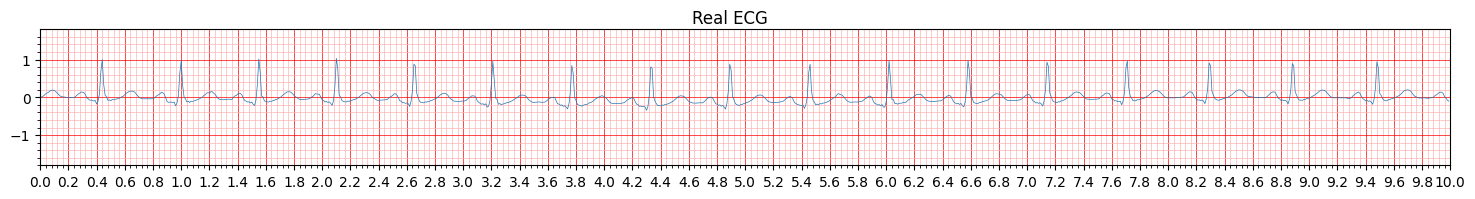

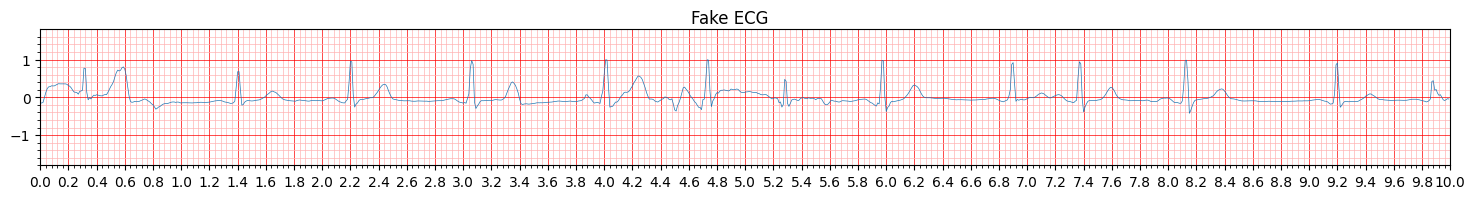

Generator Accuracy: 0.0
Generator Mean Loss: 0.7075358
Discriminator Accuracy: 0.4375
Discriminator Mean Loss: 0.68526536
epoch 127
epoch 128
epoch 129
epoch 130
epoch 131
epoch 132
epoch 133
epoch 134
epoch 135
epoch 136
epoch 137
epoch 138
epoch 139
epoch 140
epoch 141
epoch 142
epoch 143
epoch 144
epoch 145
epoch 146
epoch 147
epoch 148
epoch 149
epoch 150
epoch 151


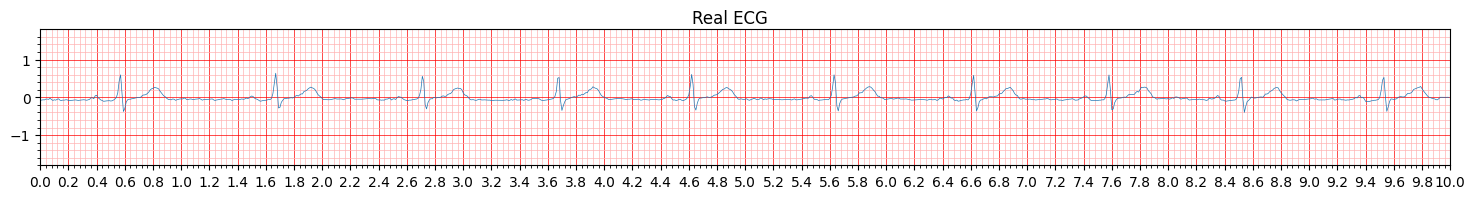

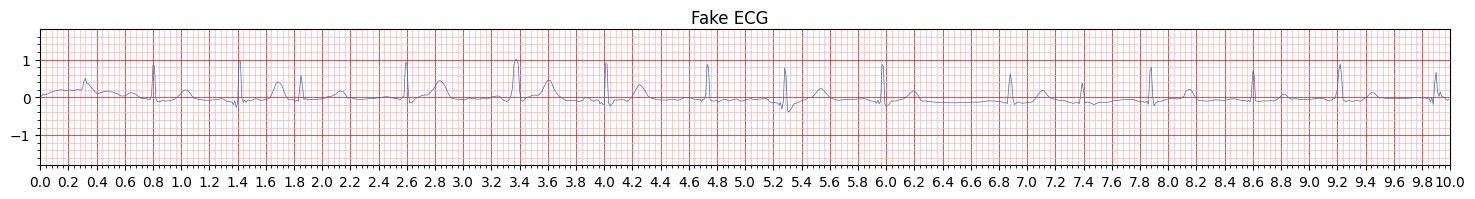

Generator Accuracy: 0.0
Generator Mean Loss: 0.7068559
Discriminator Accuracy: 0.421875
Discriminator Mean Loss: 0.6839113
epoch 152
epoch 153
epoch 154
epoch 155
epoch 156
epoch 157
epoch 158
epoch 159
epoch 160
epoch 161
epoch 162
epoch 163
epoch 164
epoch 165
epoch 166
epoch 167
epoch 168
epoch 169
epoch 170
epoch 171
epoch 172
epoch 173
epoch 174
epoch 175
epoch 176


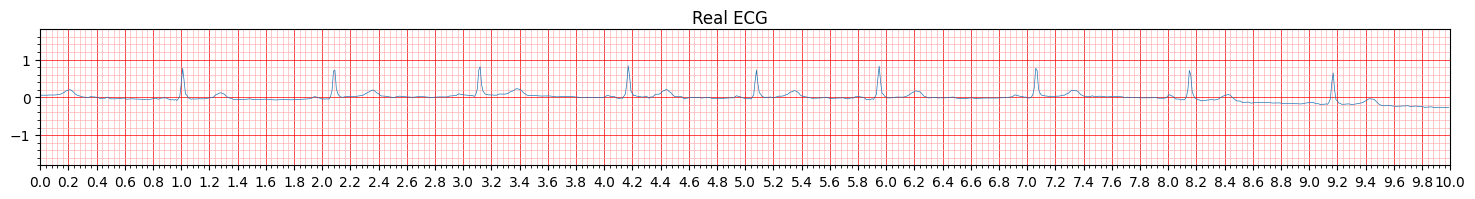

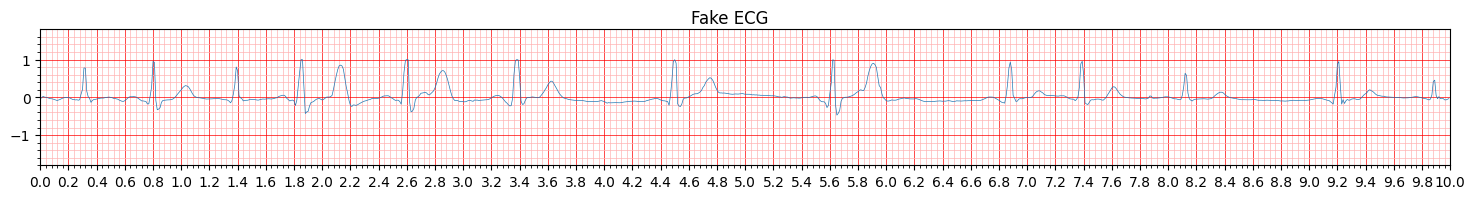

Generator Accuracy: 0.0
Generator Mean Loss: 0.7043635
Discriminator Accuracy: 0.546875
Discriminator Mean Loss: 0.68142045
epoch 177
epoch 178
epoch 179
epoch 180
epoch 181
epoch 182
epoch 183
epoch 184
epoch 185
epoch 186
epoch 187
epoch 188
epoch 189
epoch 190
epoch 191
epoch 192
epoch 193
epoch 194
epoch 195
epoch 196
epoch 197
epoch 198
epoch 199
epoch 200
epoch 201


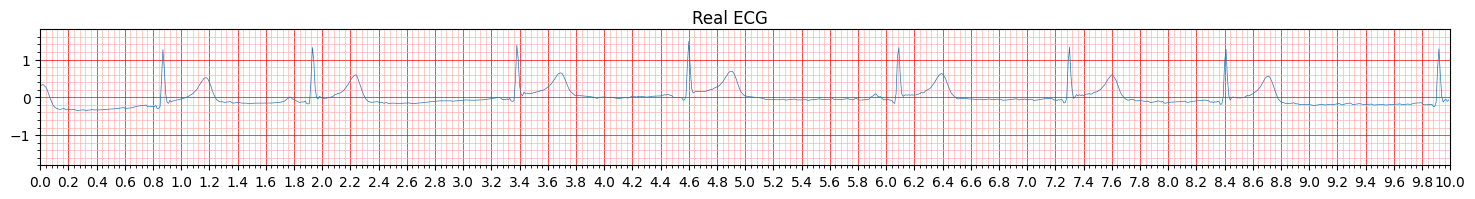

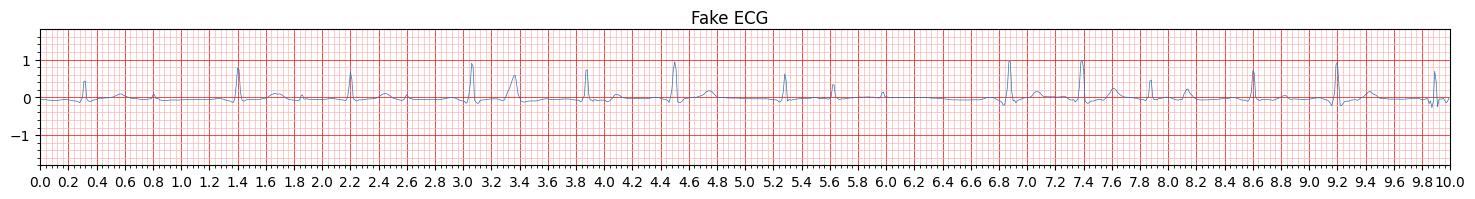

Generator Accuracy: 0.21875
Generator Mean Loss: 0.6967289
Discriminator Accuracy: 0.578125
Discriminator Mean Loss: 0.6822066
epoch 202
epoch 203
epoch 204
epoch 205
epoch 206
epoch 207
epoch 208
epoch 209
epoch 210
epoch 211
epoch 212
epoch 213
epoch 214
epoch 215
epoch 216
epoch 217
epoch 218
epoch 219
epoch 220
epoch 221
epoch 222
epoch 223
epoch 224
epoch 225
epoch 226


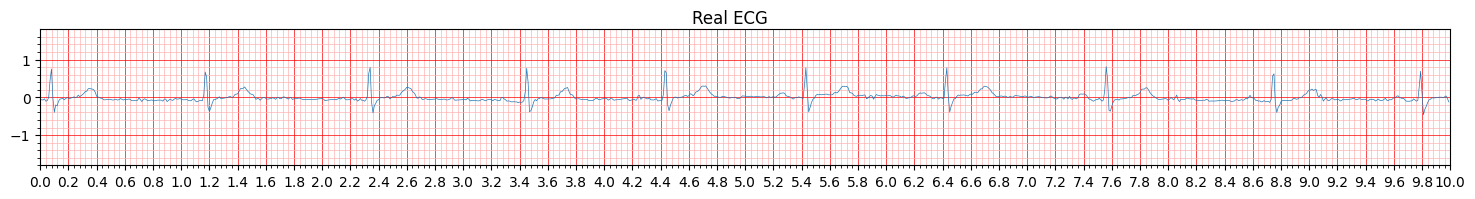

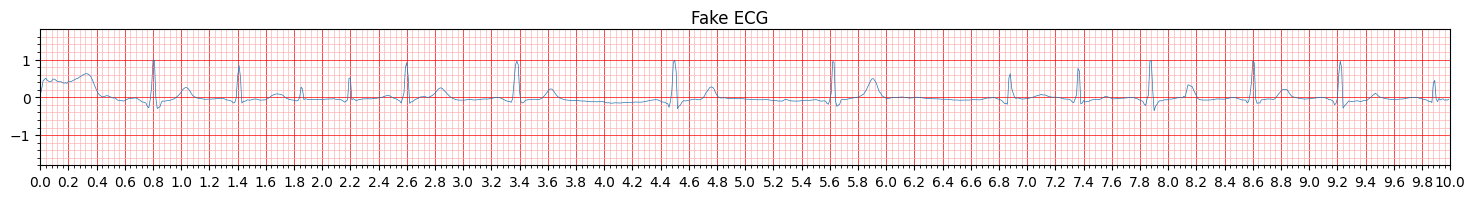

Generator Accuracy: 0.453125
Generator Mean Loss: 0.69196963
Discriminator Accuracy: 0.5
Discriminator Mean Loss: 0.68769634
epoch 227
epoch 228
epoch 229
epoch 230
epoch 231
epoch 232
epoch 233
epoch 234
epoch 235
epoch 236
epoch 237
epoch 238
epoch 239
epoch 240
epoch 241
epoch 242
epoch 243
epoch 244
epoch 245
epoch 246
epoch 247
epoch 248
epoch 249
epoch 250
epoch 251


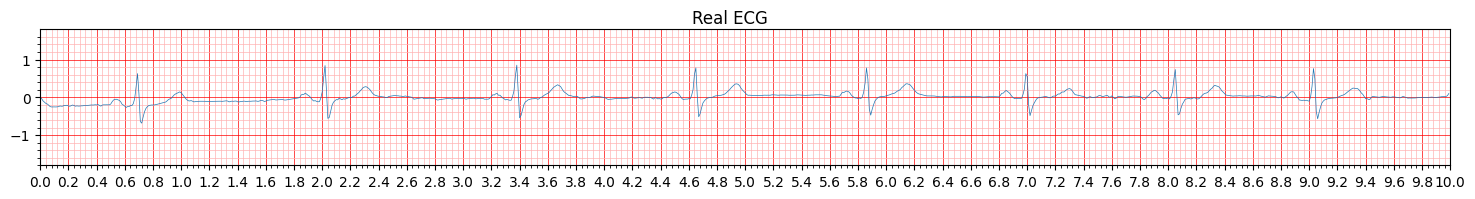

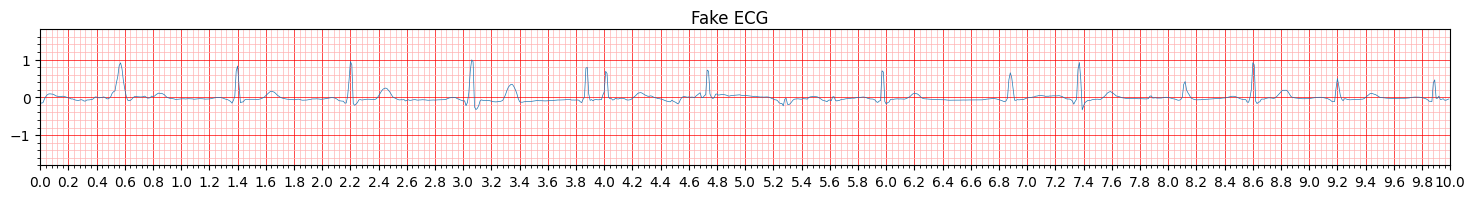

Generator Accuracy: 0.1875
Generator Mean Loss: 0.6925269
Discriminator Accuracy: 0.59375
Discriminator Mean Loss: 0.68545777
epoch 252
epoch 253
epoch 254
epoch 255
epoch 256
epoch 257
epoch 258
epoch 259
epoch 260
epoch 261
epoch 262
epoch 263
epoch 264
epoch 265
epoch 266
epoch 267
epoch 268
epoch 269
epoch 270
epoch 271
epoch 272
epoch 273
epoch 274
epoch 275
epoch 276


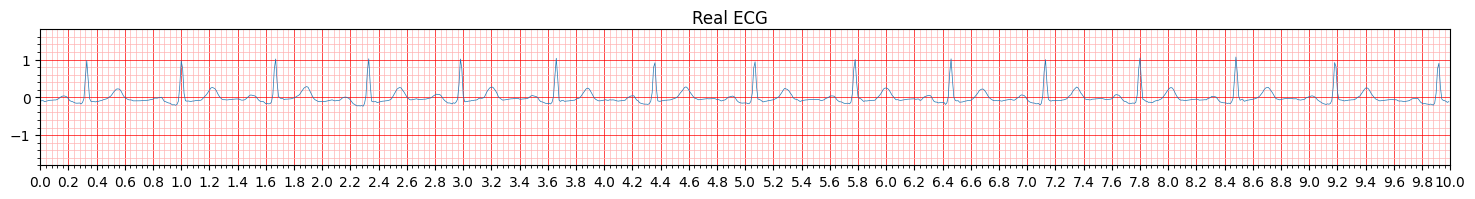

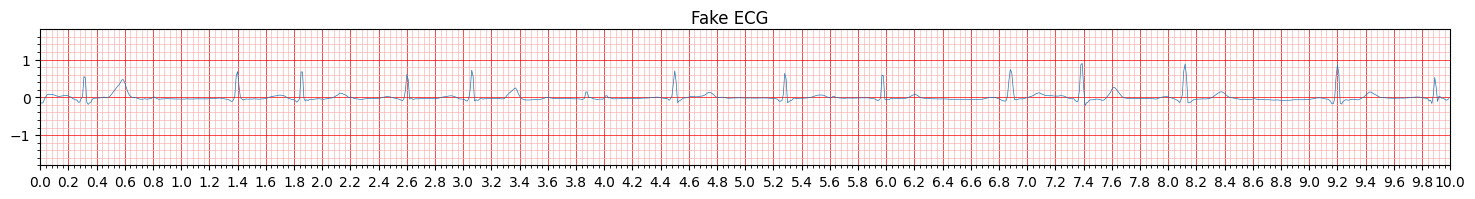

Generator Accuracy: 0.296875
Generator Mean Loss: 0.6935398
Discriminator Accuracy: 0.40625
Discriminator Mean Loss: 0.6867403
epoch 277
epoch 278
epoch 279
epoch 280
epoch 281
epoch 282
epoch 283
epoch 284
epoch 285
epoch 286
epoch 287
epoch 288
epoch 289
epoch 290
epoch 291
epoch 292
epoch 293
epoch 294
epoch 295
epoch 296
epoch 297
epoch 298
epoch 299
epoch 300
epoch 301


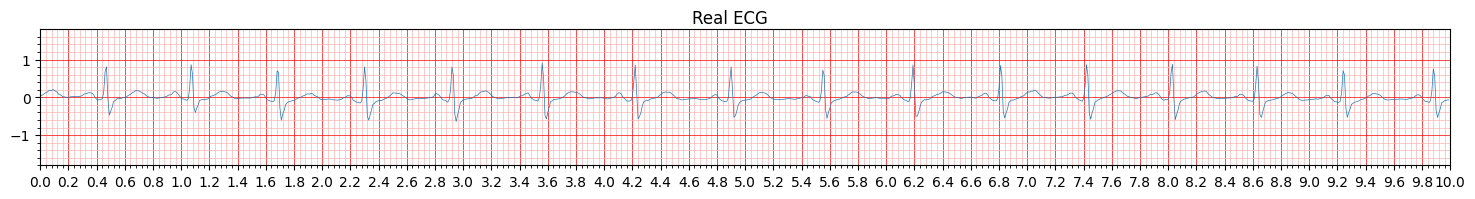

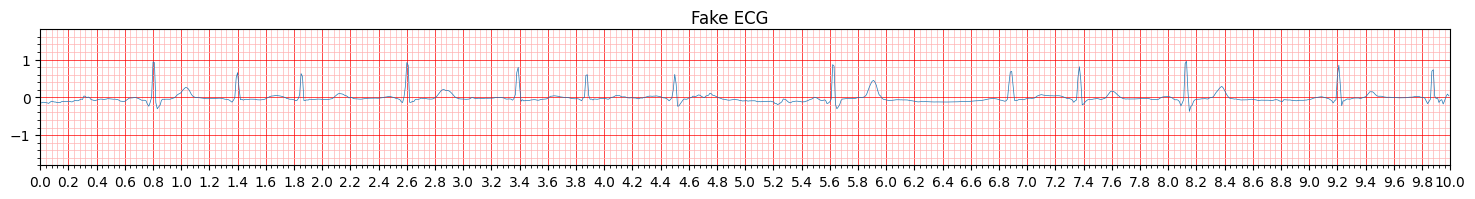

Generator Accuracy: 0.15625
Generator Mean Loss: 0.69469136
Discriminator Accuracy: 0.578125
Discriminator Mean Loss: 0.6858624
epoch 302
epoch 303
epoch 304
epoch 305
epoch 306
epoch 307
epoch 308
epoch 309
epoch 310
epoch 311
epoch 312
epoch 313
epoch 314
epoch 315
epoch 316
epoch 317
epoch 318
epoch 319
epoch 320
epoch 321
epoch 322
epoch 323
epoch 324
epoch 325
epoch 326


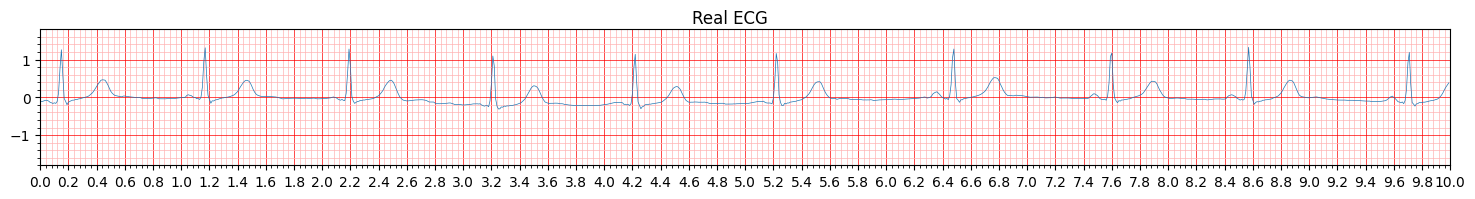

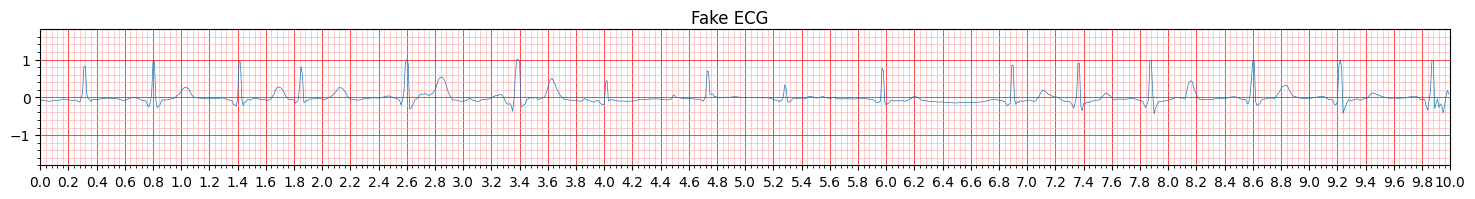

Generator Accuracy: 0.140625
Generator Mean Loss: 0.69531006
Discriminator Accuracy: 0.453125
Discriminator Mean Loss: 0.6850712
epoch 327
epoch 328
epoch 329
epoch 330
epoch 331
epoch 332
epoch 333
epoch 334
epoch 335
epoch 336
epoch 337
epoch 338
epoch 339
epoch 340
epoch 341
epoch 342
epoch 343
epoch 344
epoch 345
epoch 346
epoch 347
epoch 348
epoch 349
epoch 350
epoch 351


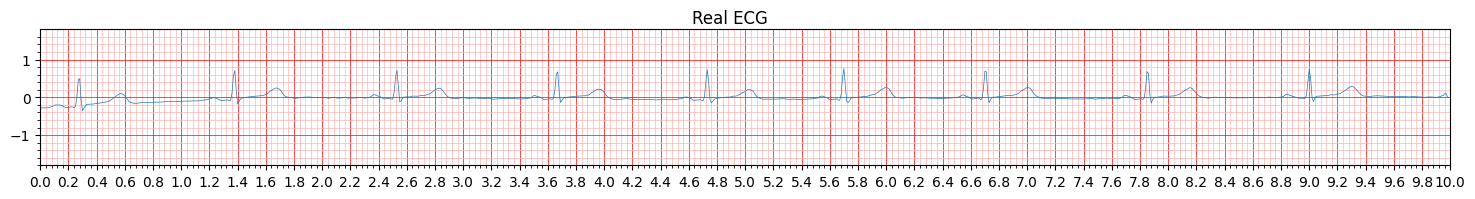

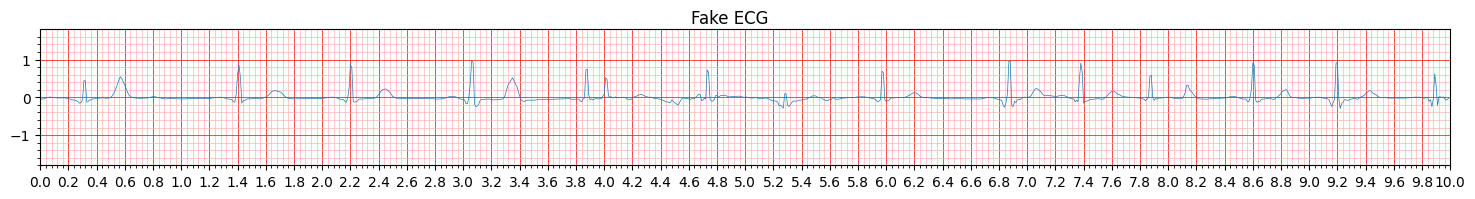

Generator Accuracy: 0.265625
Generator Mean Loss: 0.6953696
Discriminator Accuracy: 0.46875
Discriminator Mean Loss: 0.6851388
epoch 352
epoch 353
epoch 354
epoch 355
epoch 356
epoch 357
epoch 358
epoch 359
epoch 360
epoch 361
epoch 362
epoch 363
epoch 364
epoch 365
epoch 366
epoch 367
epoch 368
epoch 369
epoch 370
epoch 371
epoch 372
epoch 373
epoch 374
epoch 375
epoch 376


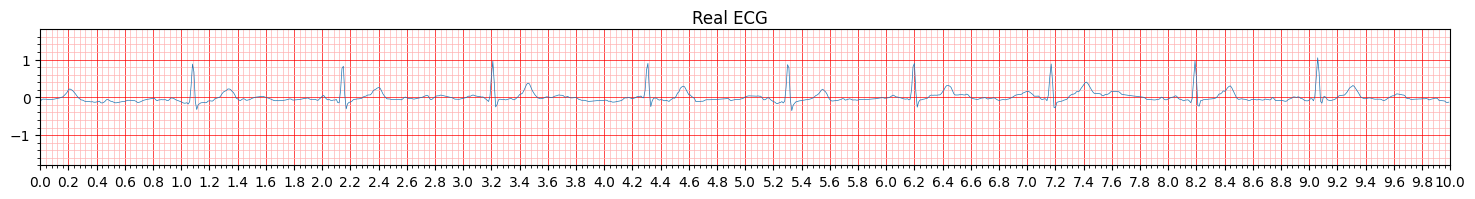

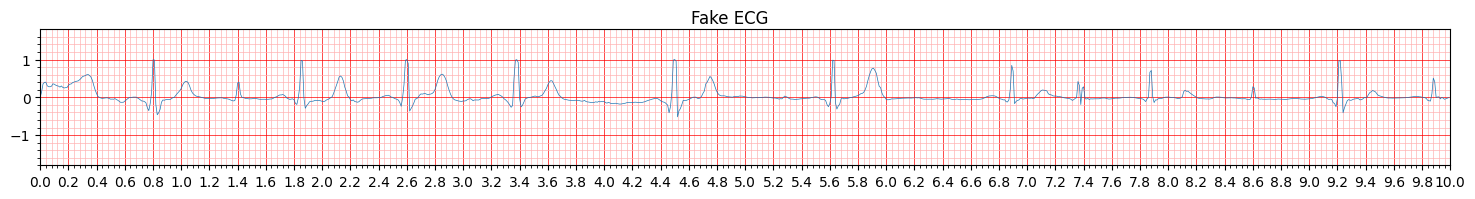

Generator Accuracy: 0.171875
Generator Mean Loss: 0.69525933
Discriminator Accuracy: 0.46875
Discriminator Mean Loss: 0.68454933
epoch 377
epoch 378
epoch 379
epoch 380
epoch 381
epoch 382
epoch 383
epoch 384
epoch 385
epoch 386
epoch 387
epoch 388
epoch 389
epoch 390
epoch 391
epoch 392
epoch 393
epoch 394
epoch 395
epoch 396
epoch 397
epoch 398
epoch 399
epoch 400
epoch 401


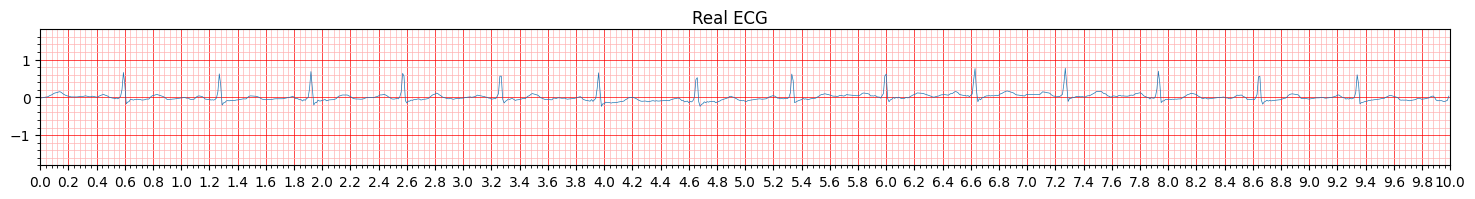

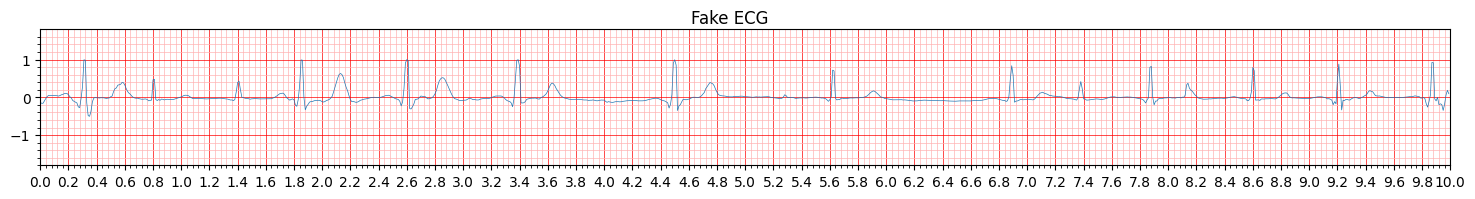

Generator Accuracy: 0.234375
Generator Mean Loss: 0.69540226
Discriminator Accuracy: 0.46875
Discriminator Mean Loss: 0.6837481
epoch 402
epoch 403
epoch 404
epoch 405
epoch 406
epoch 407
epoch 408
epoch 409
epoch 410
epoch 411
epoch 412
epoch 413
epoch 414
epoch 415
epoch 416
epoch 417
epoch 418
epoch 419
epoch 420
epoch 421
epoch 422
epoch 423
epoch 424
epoch 425
epoch 426


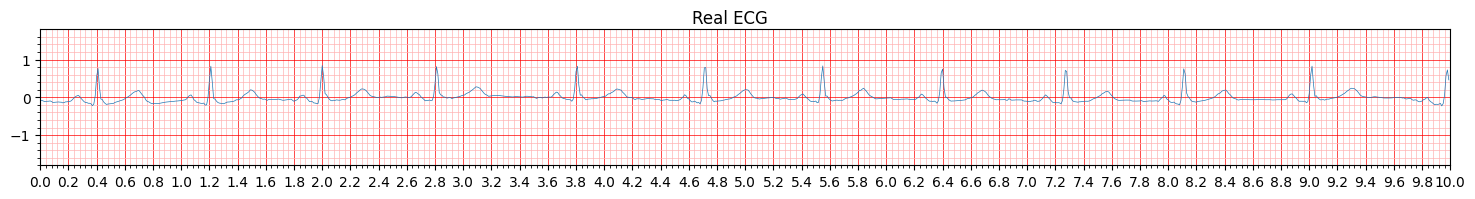

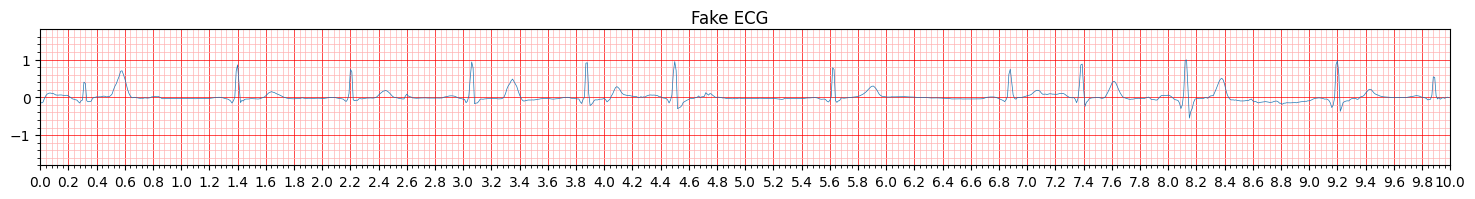

Generator Accuracy: 0.3125
Generator Mean Loss: 0.695579
Discriminator Accuracy: 0.484375
Discriminator Mean Loss: 0.6840733
epoch 427
epoch 428
epoch 429
epoch 430
epoch 431
epoch 432
epoch 433
epoch 434
epoch 435
epoch 436
epoch 437
epoch 438
epoch 439
epoch 440
epoch 441
epoch 442
epoch 443
epoch 444
epoch 445
epoch 446
epoch 447
epoch 448
epoch 449
epoch 450
epoch 451


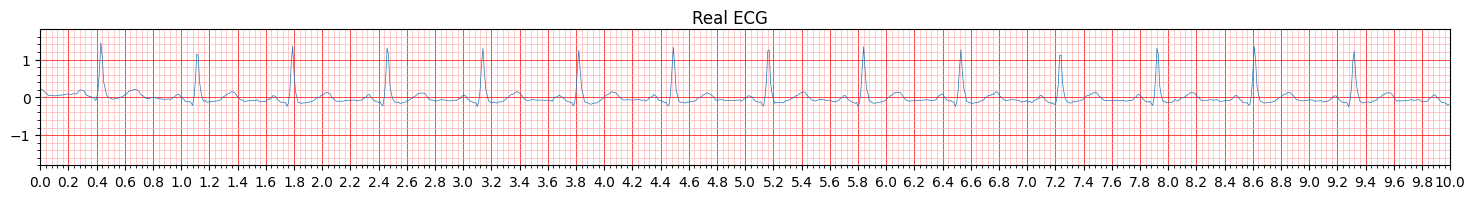

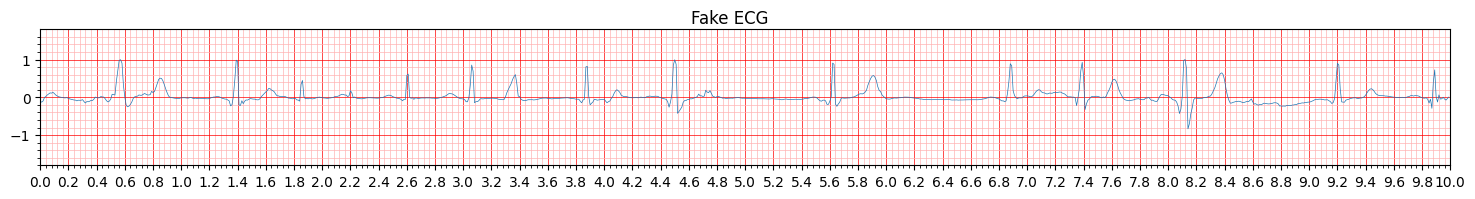

Generator Accuracy: 0.28125
Generator Mean Loss: 0.6946383
Discriminator Accuracy: 0.515625
Discriminator Mean Loss: 0.6860824
epoch 452
epoch 453
epoch 454
epoch 455
epoch 456
epoch 457
epoch 458
epoch 459
epoch 460
epoch 461
epoch 462
epoch 463
epoch 464
epoch 465
epoch 466
epoch 467
epoch 468
epoch 469
epoch 470
epoch 471
epoch 472
epoch 473
epoch 474
epoch 475
epoch 476


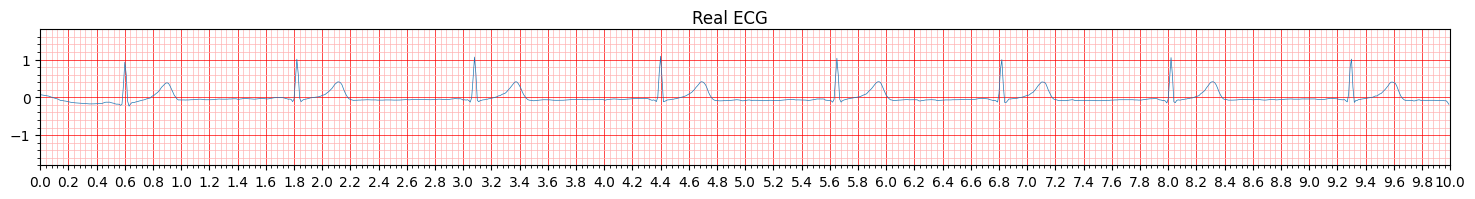

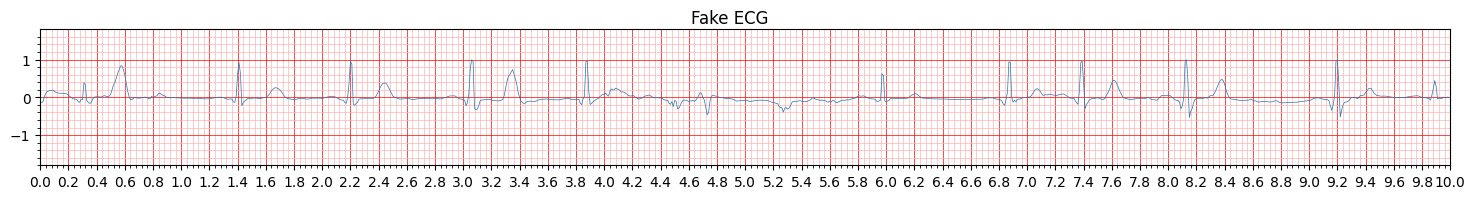

Generator Accuracy: 0.21875
Generator Mean Loss: 0.6954542
Discriminator Accuracy: 0.515625
Discriminator Mean Loss: 0.68531823
epoch 477
epoch 478
epoch 479
epoch 480
epoch 481
epoch 482
epoch 483
epoch 484
epoch 485
epoch 486
epoch 487
epoch 488
epoch 489
epoch 490
epoch 491
epoch 492
epoch 493
epoch 494
epoch 495
epoch 496
epoch 497
epoch 498
epoch 499


In [13]:
# Training hyperparameters
batch_size = 64
latent_dim = 12
steps = len(X_sub) // batch_size
half_batch = batch_size // 2
epochs = 500

# Initialize optimizers with initial learning rates for generator and discriminator
init_lr_disc = 0.001
init_lr_gen = 0.002
opt_disc = tf.keras.optimizers.Adam(learning_rate=init_lr_disc, beta_1=0.5, beta_2=0.9)
opt_gen = tf.keras.optimizers.Adam(learning_rate=init_lr_gen, beta_1=0.5, beta_2=0.9)

# Displaying the initial state before training
print("Before training:")
res = gen(generate_latent_points(12, 1))
compare_real_and_gen_ecg2(res)
print("-------------------")

# Training loop
for epoch in range(epochs):
    # Adjust learning rates every 25 epochs
    if epoch % 25 == True:
        init_lr_disc = init_lr_disc / 2
        init_lr_gen = init_lr_gen / 2
        opt_disc.lr = init_lr_disc
        opt_gen.lr = init_lr_gen
    
    # Lists to store loss values for generator and discriminator for the epoch
    accu_loss_gan = []
    accu_loss_disc = []
    print("epoch {}".format(epoch))
    
    # Training step
    for step in range(steps):
        # Generate real and fake samples
        x_real, y_real = generate_real_samples(X_sub, half_batch)
        x_fake, y_fake = generate_fake_samples(latent_dim, gen, half_batch)
        
        # Combine real and fake samples and shuffle
        X_train = np.vstack([x_real, x_fake])
        y_train = np.vstack([y_real, y_fake])
        p = np.random.permutation(len(y_train))
        
        # Train discriminator
        with tf.GradientTape() as tape:
            # Predict the realness of the shuffled images using the discriminator.
            pred_disc = disc(X_train[p])
            # Calculate loss (Dicrim Performance)
            loss_disc = tf.keras.losses.binary_crossentropy(y_train[p], pred_disc)
        accu_loss_disc.append(loss_disc)
        # Updating the gradient to minimize loss
        grads = tape.gradient(loss_disc, disc.trainable_variables)
        opt_disc.apply_gradients(zip(grads, disc.trainable_variables))
        
        # Train generator
        with tf.GradientTape() as tape:
            x_latent = generate_latent_points(latent_dim, batch_size)
            x_gan = gen(x_latent)
            y_gan = np.ones((batch_size, 1))
            pred_gan = disc(x_gan)
            # We are measuring the Generator's ability to fool the discriminator
            loss_gan = tf.keras.losses.binary_crossentropy(y_gan, pred_gan)
        
        accu_loss_gan.append(loss_gan)
        # Applying new gradient again
        grads = tape.gradient(loss_gan, gen.trainable_variables)
        opt_gen.apply_gradients(zip(grads, gen.trainable_variables))

    # Evaluate and display metrics every 25 epochs
    if epoch % 25 == 1:
        res = gen(generate_latent_points(12, 1))
        compare_real_and_gen_ecg2(res)

        gan_true_labels = np.ones(batch_size) # since we want the discriminator to think they're real
        gan_pred_labels = (np.asarray(pred_gan).ravel() > 0.5).astype(int) # convert probabilities to class labels using 0.5 threshold
        gen_accuracy = accuracy_score(gan_true_labels, gan_pred_labels)

        disc_true_labels = y_train.ravel() # real ECGs have label 1, fake ones have label 0
        disc_pred_labels = (np.asarray(pred_disc).ravel() > 0.5).astype(int) # convert probabilities to class labels using 0.5 threshold
        disc_accuracy = accuracy_score(disc_true_labels, disc_pred_labels)

        print("Generator Accuracy:", gen_accuracy)
        print("Generator Mean Loss:", np.mean(np.asarray(accu_loss_gan)))
        print("Discriminator Accuracy:", disc_accuracy)
        print("Discriminator Mean Loss:", np.mean(np.asarray(accu_loss_disc)))



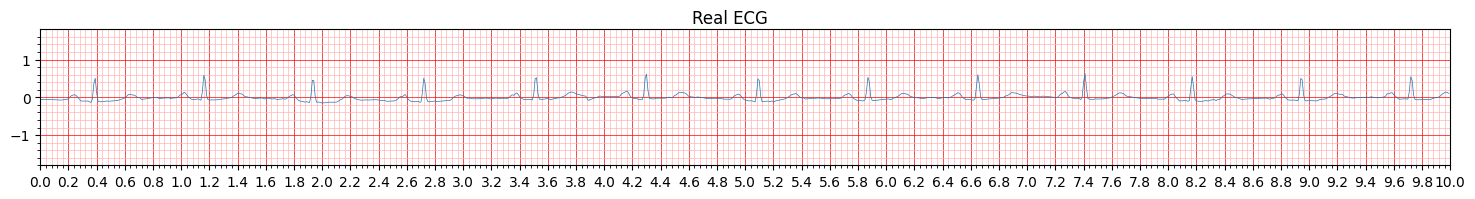

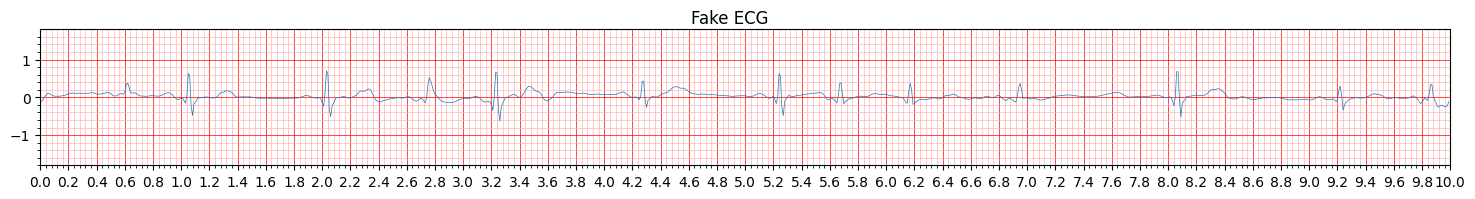

In [ ]:
compare_real_and_gen_ecg2(res)

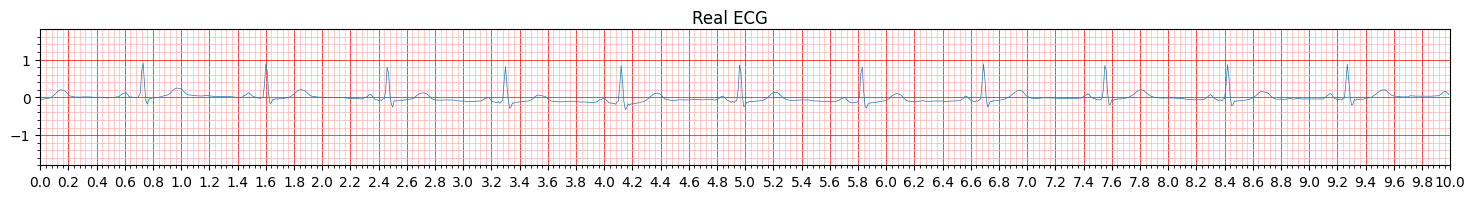

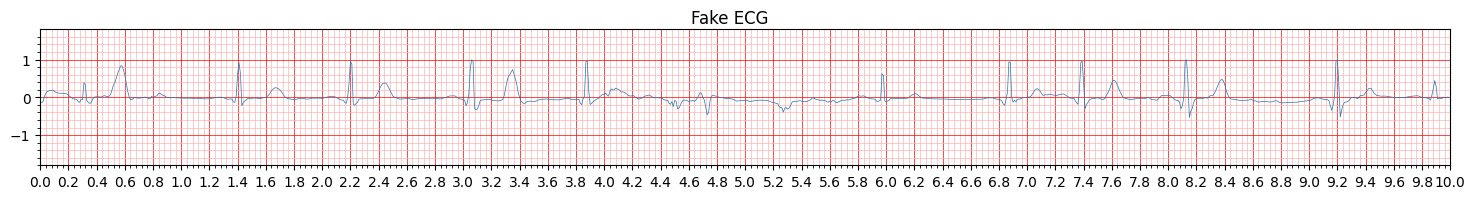

In [44]:
compare_real_and_gen_ecg2(res)

In [ ]:
gen.save_weights("gen3_weights.h5")

In [ ]:
disc.save_weights("disc3_weights.h5")